##### 2020 George Mihaila.

# Find new sentiments in text data


<td>
    <a target="_blank" href="https://jupyterlab.hpc.unt.edu/"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run on Talon</a>
</td>
<td>
  <a target="_blank" href="https://github.com/gmihaila/unt_hpc/blob/master/workshops/march_3_2019/README.md"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</br>

The main purpose of this tutorial is to target a particular Natural Language Processing (NLP) problem, in this case Sentiment Analysis, and use GPUs for great speedup.

Walkthoughs:

### Dataset used:
* [IMDB moview reviews sentiment dataset](http://ai.stanford.edu/%7Eamaas/data/sentiment/): This is a dataset for binary sentiment classification containing a set of **25,000** highly polar movie reviews for training, and **25,000** for testing. For this tutorial we will combine the train and test data for a total of **50,000 movies reviews** text data and their negative/positive labels.


### Content:

 * Train custom word embeddings using a small Neural Network.
 * Use Lime to explain model predictions.
 * Use the embedding model to create review embeddings.
 * Use GPU to perform kmeans clustering on all 50,000 movies reviews.
 * Find the best splitting K using the Elbow method and Silhouette score.
 * Use k=2 on kmeans and plot the sentiments on both predicted clusters and true labels.
 * Observe the overlap between the predcited labels and true labels and asociate labels to clusters. Visualize the clusters.
 * Try to find a third sentiment using k=3. Observe the overlab between predicted labels and true labels. Visualize the clusters.
 * Repeat previous experiments using different k and observe predicitons overlp with true labels. Visualize the clusters.
 * Visualize samples of text that are predicted with various sentiments.

## NLP - Fine-grained Sentiment Analysis

For most cases sentiment classifiers are used in binary classification (just positive or negative sentiment). That is because fine-grained sentiment classification is a significantly more challenging task! 

The typical breakdown of fine-grained sentiment uses five discrete classes, as shown below. As one might imagine, models very easily err on either side of the strong/weak sentiment intensities thanks to the wonderful subtleties of human language.

![alt text](https://miro.medium.com/max/705/1*ug8kyqUlnqEuo3LhHfNypg.png)

Binary class labels may be sufficient for studying large-scale positive/negative sentiment trends in text data such as Tweets, product reviews or customer feedback, but they do have their limitations. 

When performing information extraction with comparative expressions, for example: 
 * “This OnePlus model X is so much better than Samsung model X.” 
  * a fine-grained analysis can provide more precise results to an automated system that prioritizes addressing customer complaints. 

 * “The location was truly disgusting ... but the people there were glorious.” 
  * dual-polarity sentences can confuse binary sentiment classifiers, leading to incorrect class predictions.

[source](https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4)



## Installs

* [Sentence-Transformers](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD): wrapper around Hugging Face [transformers](https://github.com/huggingface/transformers) library and built for document embedding using state of the art language models like BERT or XLNET.

## Dataset

* **data/imdb_reviews_subwords8k_text_features.pickle** contains the text encoder - decoder binary file of type `info.features['text'].encoder` from `tensorflow_datasets`
   
* **data/imdb_reviews_50k.csv** contains all movie revies and their sentiments:
  
| review                                            	| sentiment 	|
|---------------------------------------------------	|-----------	|
| This was an absolutely terrible movie. Don't b... 	| 0         	|
| I have been known to fall asleep during films,... 	| 0         	|

## Imports

In [1]:
import os
# avoid using GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = ''
import torch
## Load TF 2.0
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords 
import nltk
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from lime.lime_text import LimeTextExplainer
import pickle

# stop words
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# data frame display setup
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

ID_SENTIMENT = {0:'Negative',
                1:'Positive'}

[nltk_data] Downloading package stopwords to /home/gm0234/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gm0234/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/cm/shared/utils/PYTHON/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Functions

In [2]:
def plt_history(history_dict, 
                acc_key='accuracy', val_acc_key='val_accuracy', 
                loss_key='loss', val_loss_key='val_loss'):
  acc = history_dict[acc_key]
  val_acc = history_dict[val_acc_key]
  loss = history_dict[loss_key]
  val_loss = history_dict[val_loss_key]
  epochs = range(1, len(acc) + 1)
  plt.subplot(1, 2, 1)
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)


  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)
  fig = plt.gcf()
  fig.set_size_inches(15, 5)
  plt.show()
  return


def predictions_overlap(model_predicitons, true_predicitons, label_decoder):
  """Find overlap between predicted labels that aren't associated with any actual classes
  and actual classes.

  """
  labels = list(set(model_predicitons))
  print("Found labels: %s\n" % labels)
  ## dicitonary with predicitons counts clusters
  predictions = {label:[] for label in labels}
  for true_label, pred_label in zip(true_predicitons, model_predicitons):
    predictions[pred_label].append(true_label)
  # data frame
  matching_df = pd.DataFrame()
  matching_df['labels'] = labels
  matching_df['cluster_match'] = ["  ".join([str(label_decoder[cluster])+":"+str(count) for cluster, count in Counter(predictions[label]).most_common()]) for label in labels]
  return matching_df


def clusters_words_plot(texts, labels, n_sentiments, pos_tag, top_clip=0, low_clip=20, stop_words=None, magnify=2):
  # low_clip and top_clip are clips of the most frequent words to show
  # pos_tag in ['VB', 'NN']
  labels_texts = {n:[] for n in range(n_sentiments)}
  for text, label in zip(texts, labels):
    labels_texts[label].append(text)
  for sentiment in range(n_sentiments):
    # fit tokenizer on texts
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts=labels_texts[sentiment])
    top_words = list(tokenizer.word_index.keys())
    if pos_tag is not None: 
      top_words = nltk.pos_tag(tokens=top_words)
      top_words = [val[0] for val in top_words if val[1]==pos_tag]
    if stop_words is not None: top_words=[word for word in top_words if word not in stop_words]
    # temporary Data Frame
    tmp_df = pd.DataFrame()
    tmp_df['words'] = top_words[top_clip:low_clip]
    tmp_df['count'] = [tokenizer.word_counts[word] for word in top_words[top_clip:low_clip]]
    # plot
    ax = sns.barplot(x='words', y='count', data=tmp_df)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')
    fig = plt.gcf()
    ax.set_title('Words Counts Sentimen %s'%sentiment)
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
  return


def show_samples(target_predicitons_class, texts, predicitons, trues, trues_id_sentiment,
                 predictions_id_sentiment, n_samples):
  samples_texts = []
  samples_labels = []

  while len(samples_texts) < n_samples:
    pick = np.random.randint(low=0, high=(len(trues)-1))
    if predicitons[pick] == target_predicitons_class:
      samples_texts.append(texts[pick])
      samples_labels.append(trues[pick])

  samples_df = pd.DataFrame()
  samples_df['Text'] = samples_texts
  samples_df['Label Sentiment'] = [trues_id_sentiment[label] for label in samples_labels]
  samples_df['Prediction Sentiment'] = [predictions_id_sentiment[target_predicitons_class] for _ in samples_labels]
  return samples_df

# Dataset Prep

## Read CSV

In [3]:
# get text_features from binary
with open('../data/imdb_reviews_subwords8k_text_features.pickle', 'rb') as handle:
    text_features = pickle.load(handle)
print('Vocabulary size:', text_features.vocab_size)

# read reviews from csv file
review_sentiments_df = pd.read_csv('../data/imdb_reviews_50k.csv')
# get reviews and sentiments
reviews_texts, reviews_sentiments = review_sentiments_df['review'].values, review_sentiments_df['sentiment'].values
# print first 2 examples
review_sentiments_df.head(n=2)

Vocabulary size: 8185


review  \
0  This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.   
1  I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all.                                                                                               

   sentiment  
0  0          
1  0

## Encode Text

In [4]:
# encode_review
reviews_encodings = [text_features.encode(review) for review in reviews_texts]
# get max length of review
max_review_length = max([len(encoding) for encoding in reviews_encodings])
# global variable
MAX_LEN = max_review_length # 500
# pad all reviews to max length
reviews_encodings = tf.keras.preprocessing.sequence.pad_sequences(sequences=reviews_encodings, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post', value=0.0)

print('reviews_encodings shape:', reviews_encodings.shape)

reviews_encodings shape: (50000, 3944)


# Simple Neural Network

## Config

In [5]:
EMBEDDING_SIZE = 16 #300 #100
BUFFER_SIZE = 1000
BATCH = 500
EPOCHS = 20

## Prep Data

In [6]:
# split train 80% - test 20% 
encodings_train, encodings_test, sentiments_train, sentiments_test = train_test_split(reviews_encodings, reviews_sentiments, train_size=0.8, shuffle=True, random_state=20)
# split train into validation 10%
encodings_train, encodings_valid, sentiments_train, sentiments_valid = train_test_split(encodings_train, sentiments_train, train_size=0.9, shuffle=True, random_state=20)
# shape (number of examples X sequence length)
print('Train shape:     ', encodings_train.shape)
print('Validation shape:', encodings_valid.shape)
print('Test shape:      ', encodings_test.shape)

Train shape:      (36000, 3944)
Validation shape: (4000, 3944)
Test shape:       (10000, 3944)


## Data Generators

In [7]:
# train generator
train_genrator = tf.data.Dataset.from_tensor_slices((encodings_train, sentiments_train))
# batching generator and shuffle
train_batches = train_genrator.batch(BATCH).shuffle(BUFFER_SIZE)
# increase speed by overlaping the preprocessing and model execution of a training step
train_batches = train_batches.prefetch(tf.data.experimental.AUTOTUNE)

# validation generator
valid_genrator = tf.data.Dataset.from_tensor_slices((encodings_valid, sentiments_valid))
# batching generator
valid_batches = valid_genrator.batch(BATCH)
# increase speed by overlaping the preprocessing and model execution of a training step
valid_genrator = valid_genrator.prefetch(tf.data.experimental.AUTOTUNE)

## Modeling

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
average (GlobalAveragePoolin (None, 16)                0         
_________________________________________________________________
hidden (Dense)               (None, 16)                272       
_________________________________________________________________
prediction (Dense)           (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________
Train for 72 steps, validate for 8 steps
Epoch 1/20
72/72 [==============================] - 14s 191ms/step - loss: 0.6929 - accuracy: 0.5104 - val_loss: 0.6924 - val_accuracy: 0.5060
Epoch 2/20
72/72 [==============================] - 11s 154ms/st

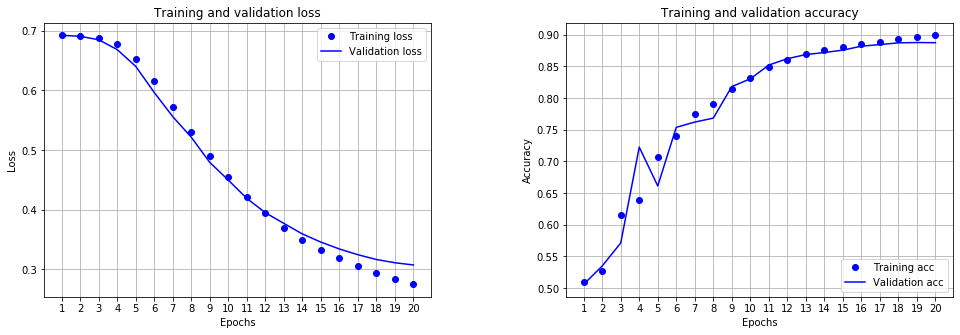

In [8]:
# build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(text_features.vocab_size, EMBEDDING_SIZE, name='embedding'))
model.add(tf.keras.layers.GlobalAveragePooling1D(name='average'))
model.add(tf.keras.layers.Dense(16, activation='elu', name='hidden'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='prediction'))
# print overview
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# train and keep track of history
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=valid_batches,
                    verbose=1)
# plot training curves
plt_history(history_dict=history.history)

## Evaluations

In [9]:
# get model predicitons
sentiments_predicitons = model.predict_classes(encodings_test)
# print evaluation report
print(classification_report(y_true=sentiments_test, y_pred=sentiments_predicitons))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      4948
           1       0.86      0.91      0.88      5052

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Explain Model

In [31]:
example_index = np.random.randint(0, len(sentiments_test)-1)

review_text = text_features.decode(encodings_test[example_index])
review_sentiment = sentiments_test[example_index]
review_prediction = int(sentiments_predicitons[example_index])

print('Review Sample:\n',review_text)
print('Sentiment:  {}'.format(ID_SENTIMENT[review_sentiment]))
print('Prediciton: {}\n'.format(ID_SENTIMENT[review_prediction]))

# explain model prediciton
def classifier_dn(strings):
  '''Takes as input list of stirngs.
  Outputs numpy array of porbabilities
  '''
  probab = []
  for string in strings:
    encoding = text_features.encode(string)
    encoding = tf.keras.preprocessing.sequence.pad_sequences(sequences=[encoding], 
                                                             maxlen=MAX_LEN, 
                                                             padding='post', 
                                                             truncating='post', 
                                                             dtype='float32')
    preds = model(encoding)[0][0]
    probab.append([(1-preds), preds])
  return np.array(probab)
# create explainer
explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(review_text,  classifier_dn, num_features=MAX_LEN)
# output to cell
exp.show_in_notebook(text=True)

Review Sample:
 The first season was great - good mix of the job and the brother and friends at home. it was actually a pretty funny show.<br /><br />Now it shows up again and the brother and the two hot chicks are gone -- and the whole thing revolves around the airline company. Even the old man who runs the company has gone downhill - way too over the top, where before it was perfect.<br /><br />That and no more Sarah Mason - one of the best looking girls in Hollywood.<br /><br />This is what happens when you let some execs get their hands on a show. You can almost see the meeting "the old man is funny, lets focus on him, make him way over the top and make it all about the airline.. it'll be a nutty version of the office!" Anyhow, no hot chicks, no watch.
Sentiment:  Negative
Prediciton: Positive



/home/gm0234/.local/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


## Custom Sample

In [32]:
custom_text = "This workshop roks!!"

# create explainer
explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(custom_text,  classifier_dn, num_features=MAX_LEN)
# output to cell
exp.show_in_notebook(text=True)

/home/gm0234/.local/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


# Get Review Embeddings

## Create Embedding Model

In [12]:
# create embedding model from previous model
embedding_model = tf.keras.Model(model.inputs, model.get_layer('average').output)
# show embedding model
print(embedding_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_input (InputLayer) [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
average (GlobalAveragePoolin (None, 16)                0         
Total params: 130,960
Trainable params: 130,960
Non-trainable params: 0
_________________________________________________________________
None


## Get Embeddings

In [13]:
# train generator
reviews_encodings_genrator = tf.data.Dataset.from_tensor_slices(reviews_encodings)
# batching generator and shuffle
reviews_encodings_genrator = reviews_encodings_genrator.batch(BATCH)
# increase speed by overlaping the preprocessing and model execution of a training step
reviews_encodings_genrator = reviews_encodings_genrator.prefetch(tf.data.experimental.AUTOTUNE)
# get review embeddings
reviews_embeddings = embedding_model.predict(reviews_encodings_genrator)

print('Review Embeddings shape: ',reviews_embeddings.shape)

Review Embeddings shape:  (50000, 16)


# Find Best K-means

In [14]:
# maximum number of clusters to use
max_n_cluster = 10

## Elbow Method
* Distortion is defined as the sum of the squared distances between each observation vector and its dominating centroid.
* Find out more about [inertia/distortion](https://scikit-learn.org/stable/modules/clustering.html#k-means)

For n_clusters = 2 Distortion is : 13.78451021599793
For n_clusters = 3 Distortion is : 9.37368682423605
For n_clusters = 4 Distortion is : 6.544926404308423
For n_clusters = 5 Distortion is : 5.119764086046565
For n_clusters = 6 Distortion is : 4.152966641613172
For n_clusters = 7 Distortion is : 3.592712741860251
For n_clusters = 8 Distortion is : 3.1669442643131127
For n_clusters = 9 Distortion is : 2.844759234372655


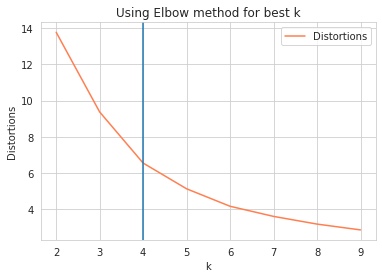

In [15]:
def best_kmeans_elbow(features, n_clusters, verbose=False, show=False):
  # list of clusters
  clusters = list(range(2, n_clusters))
  # store all distortions
  distortions = []
  # apply kmeans for each cluster values
  for n_clusters in clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(features)
    # get distortions
    distortion = kmean_model.inertia_
    distortions.append(distortion)
    # print output
    if verbose: print("For n_clusters =", n_clusters, "Distortion is :", distortion)
  # locate knee
  kn = KneeLocator(clusters, distortions, curve='convex', direction='decreasing')
  best_k = int(kn.knee)
  # plot
  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      distortions,
                      color="coral", 
                      label="Distortions")
  plot.set(xlabel='k', ylabel='Distortions')
  plot.set_title('Using Elbow method for best k')
  plot.axvline(x=best_k)
  if show: plt.show()
  fig = plot.get_figure()
#   fig.savefig("elbow_distortions.png")
  return

# run function
best_kmeans_elbow(features=reviews_embeddings, 
                  n_clusters=max_n_cluster, 
                  verbose=True)

## Silhouette Method [time consuming]

* The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. More info [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

For n_clusters = 2 The average silhouette_score is : 0.49350548
For n_clusters = 3 The average silhouette_score is : 0.4219904
For n_clusters = 4 The average silhouette_score is : 0.45567605
For n_clusters = 5 The average silhouette_score is : 0.41508847
For n_clusters = 6 The average silhouette_score is : 0.40903747
For n_clusters = 7 The average silhouette_score is : 0.38412225
For n_clusters = 8 The average silhouette_score is : 0.37516442
For n_clusters = 9 The average silhouette_score is : 0.39078256


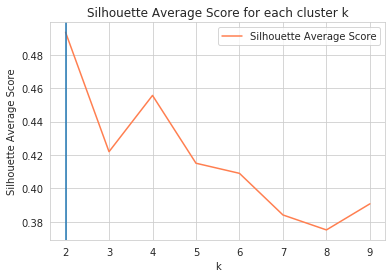

In [16]:
def best_kmeans_silhouette(features, n_clusters):
  # get list of clusters  
  clusters = list(range(2, n_clusters))
  # store all silhouttes values
  silhouettes = []
  # run k-means for each cluter
  for n_clusters in clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(np.array(features))
    # get labels predicted
    cluster_labels = kmean_model.predict(features)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouettes.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
  # find best k
  best_k = clusters[silhouettes.index(max(silhouettes))]
  # plot
  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      silhouettes,
                      color="coral", 
                      label="Silhouette Average Score")
  plot.set(xlabel='k', ylabel='Silhouette Average Score')
  plot.set_title('Silhouette Average Score for each cluster k')
  plot.axvline(x=best_k)
  fig = plot.get_figure()
#   fig.savefig("silhouette_avg.png")
  return

# run fucntion
best_kmeans_silhouette(features=reviews_embeddings, 
                       n_clusters=max_n_cluster)

# Run Best k-means model

In [17]:
# pick best k based on previous experiments
best_k = 2
# build model using specific k
kmean_model = KMeans(n_clusters=best_k)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
best_kmeans_labels = kmean_model.labels_

## PCA Visualize

In [18]:
def pca_reduction(features, labels_values, n_components, random_state=20, 
                  label_decoder=None, title='PCA Plot', magnify=2):
  pca_cuml = PCA(n_components=n_components,
                   random_state=random_state)
  reduced_features = pca_cuml.fit_transform(features)

  # plot
  if (n_components==2) and (labels_values is not None):
    # create data frame
    reduced_features_df = pd.DataFrame()
    reduced_features_df['x'] = [float(value) for value in reduced_features[:,0]]
    reduced_features_df['y'] = [float(value) for value in reduced_features[:,1]]
    if label_decoder is not None:
      reduced_features_df['clusters'] = [label_decoder[int(value)] for value in labels_values]
    else:
      reduced_features_df['clusters'] = [int(value) for value in labels_values]
    #plot data with seaborn
    cluster_plot = sns.lmplot(data=reduced_features_df, x='x', y='y', hue='clusters', fit_reg=False, legend=True, legend_out=True)
    plt.title(title)
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
#     cluster_plot.savefig("pca_plot.png")
  return reduced_features

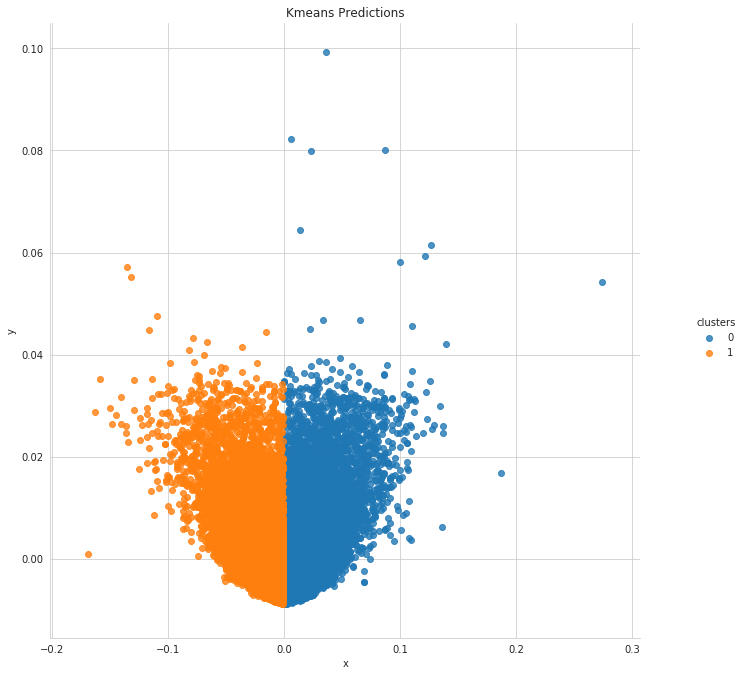

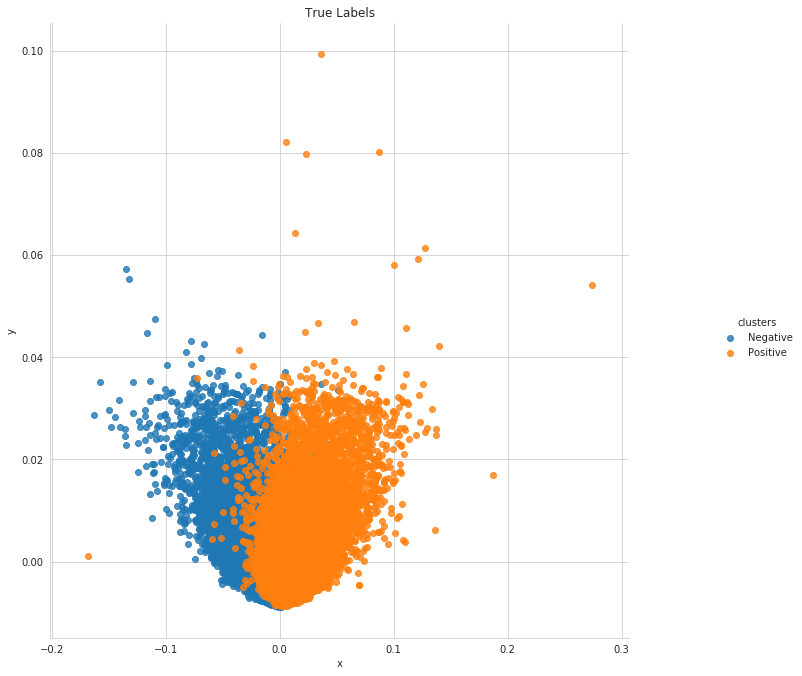



Found labels: [0, 1]



labels                  cluster_match
0  0       Positive:22805  Negative:2966
1  1       Negative:22034  Positive:2195

In [19]:
reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=best_kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=None,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')

print('\n')
matching_df = predictions_overlap(model_predicitons=best_kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

# K Means Sentiments

## k=3 sentiments

In [20]:
k_sentiments = 3
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [21]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2]



labels                   cluster_match
0  0       Negative:11522  Positive:243  
1  1       Positive:12793  Negative:306  
2  2       Negative:13172  Positive:11964

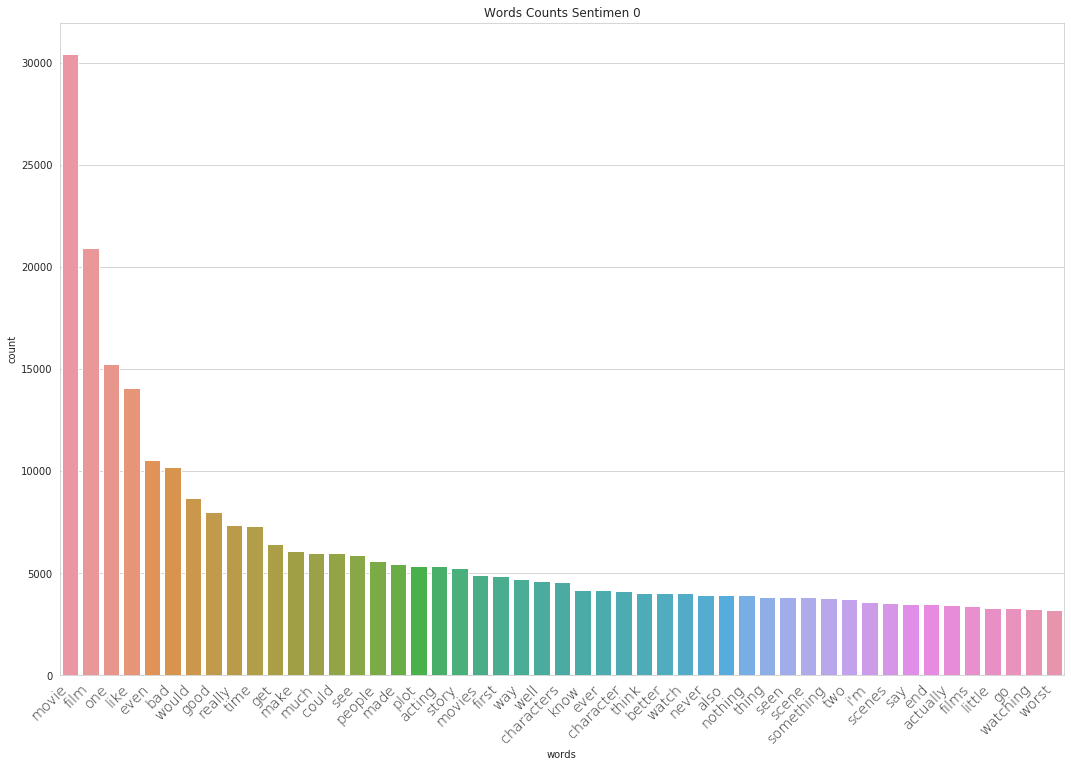

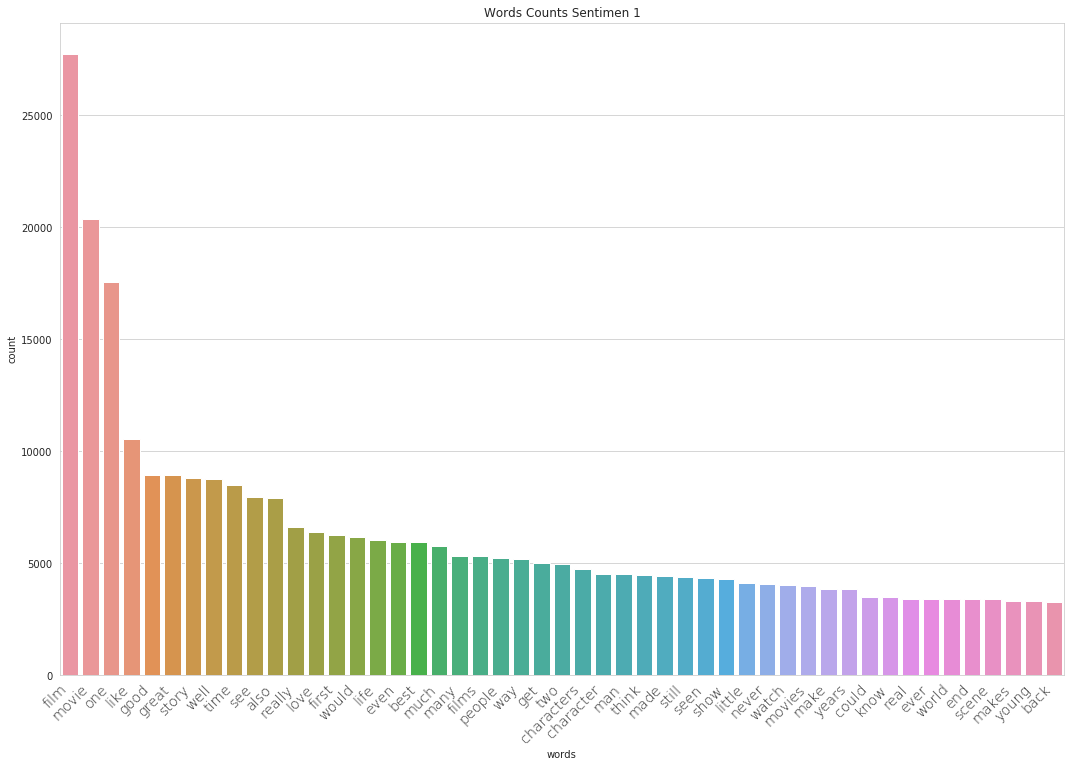

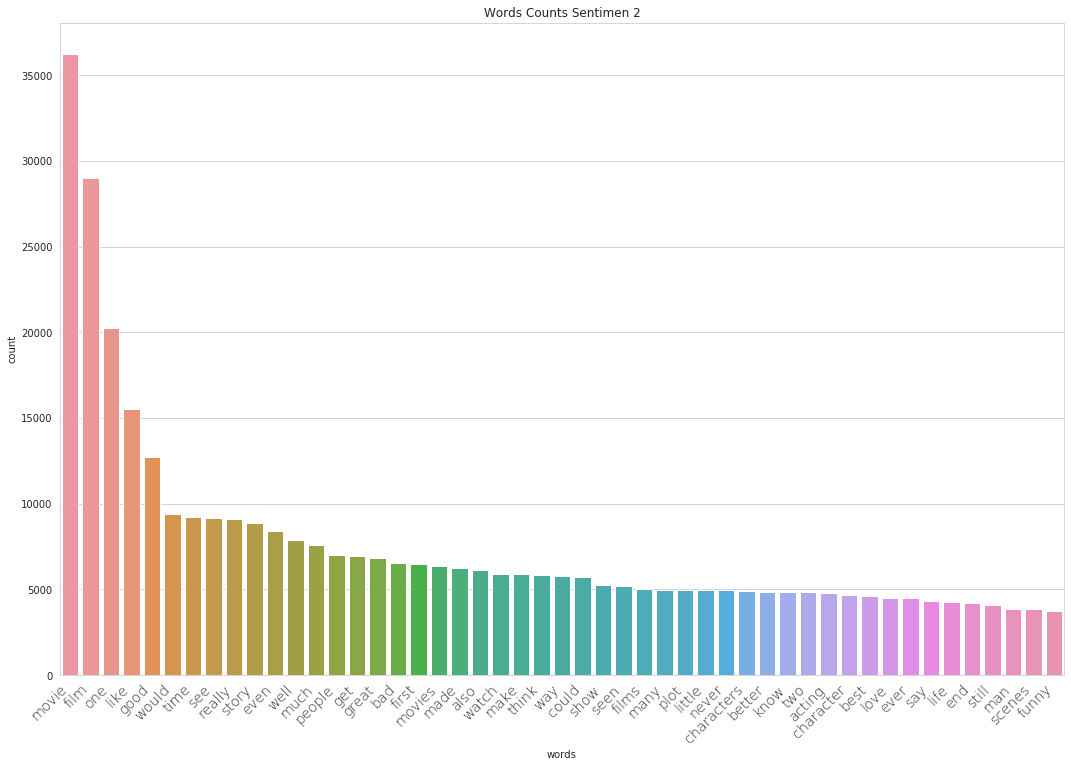

In [22]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), #None, #stopwords.words('english'), 
                    magnify=3)

### Visualize

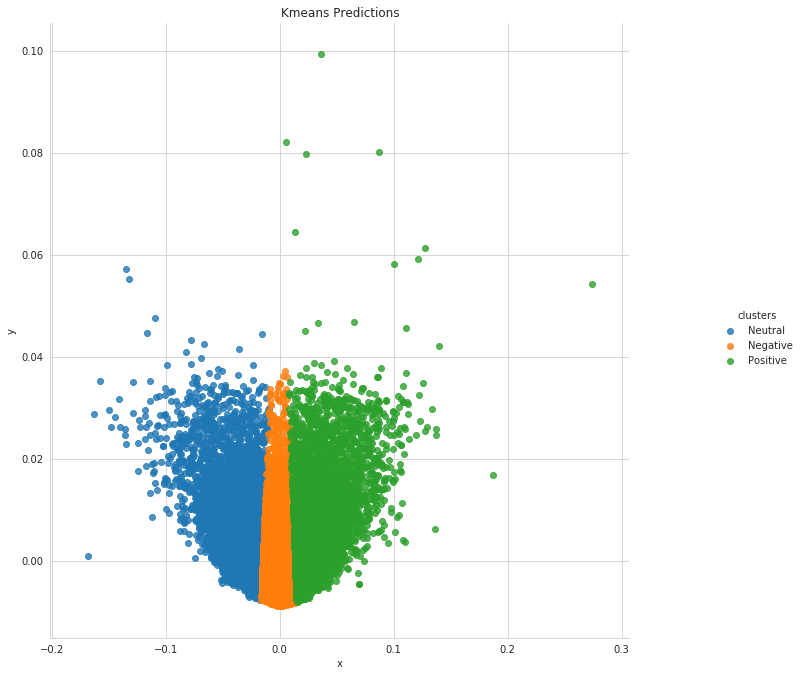

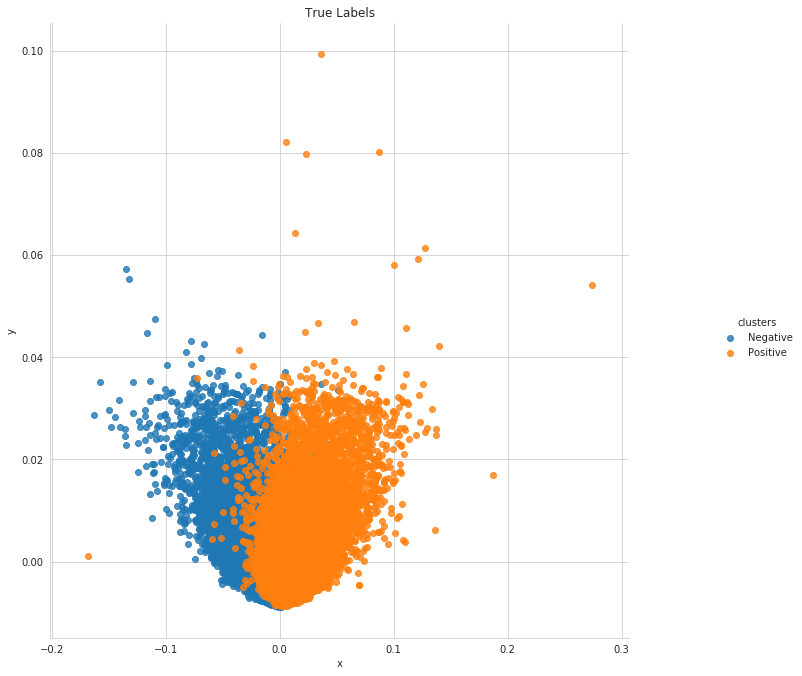

In [23]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [24]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                          trues=reviews_sentiments, 
                          trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                          predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  \
0  The premise sucked me in, but it was clear about 30 seconds in that this was either David Lynch or something seriously terrible. Interesting to watch just to run through the fundamentalist laundry list. I can be a sucker for a stirring spiritual piece (Romero comes to mind), but there was nothing spiritual whatsoever about this one. The message seems to be that we must all pretend we have an iq of 80 (or simply get a lobotomy - Jennifer what happened to ya?) and blindly follow the Bible without any sort of self-examination whatsoever or we'll trigger the second coming. It's the kind of attitude that makes people fly jumbo jets into 110 story buildings (I work around the corner from the site of the former WTC). I like to think that God is a little greater than that.                                                                                                                                                                                                                                                                       
1  This music is totally out of touch with the film, showing up now and then as wagnerian bombast and Lone Ranger hurry-up, otherwise nonexistent. The acting, outside of the two principals, is nonexistent. It would have been an excellent student film. The Russian soldiers are just models trying to act. The constant interruptions with wow-explosive-camera angles and monocolor clips of pieces of people were quite irritating, but that's just a personal feeling. The story line isn't worse than others, actually not worse than most, completely ignoring logic and reason and reality. At least nobody walked in front of a machine gun for three minutes without being hit. The three top-level bad guys were campy.                                                                                                                                                                                                                                                                                                                                            
2  This is truly, without exaggerating, one of the worst Slasher movies ever made. I know, it came out in the 80's following a tendency started by "Friday the 13th". "The Prey" copies the fore-mentioned movie in many aspects. The woods setting, the killer, the dumb teens, the gore, etc.<br /><br />But "The Prey" is as bad as you might expect. I didn't even remember about it if it wasn't for coincidence.<br /><br />Well, the killer is in fact human so don't expect a supernatural killer in the likes of Jason. The situations rather boring and lack of tension, gore, violence, etc. It just does not works for a slasher flick.<br /><br />The acting is simply horrid. The score is horrible! a combination of boring instruments with cheesy 80's tunes?! I won't even mention the technical aspects of the movie because believe me, it seems that it cost only 20 dollars.<br /><br />Please avoid this one like the plague. It's one of the worst movies I've ever seen, and that's something to say. Thank God it seems to have vanished from earth.   

  Label Sentiment Prediction Sentiment  
0  Negative        Neutral              
1  Negative        Neutral              
2  Negative        Neutral

## k=4 sentiments

In [25]:
k_sentiments = 4
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [26]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2, 3]



labels                  cluster_match
0  0       Negative:17427  Positive:2407
1  1       Positive:17899  Negative:2620
2  2       Negative:4902  Positive:67   
3  3       Positive:4627  Negative:51

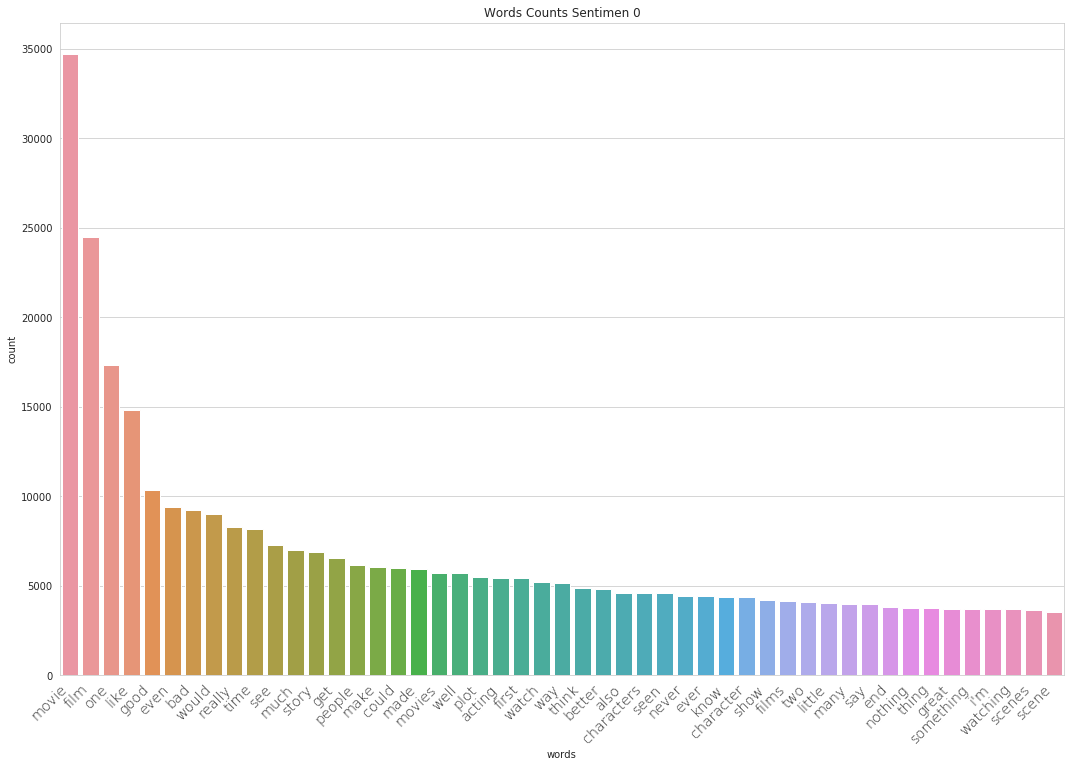

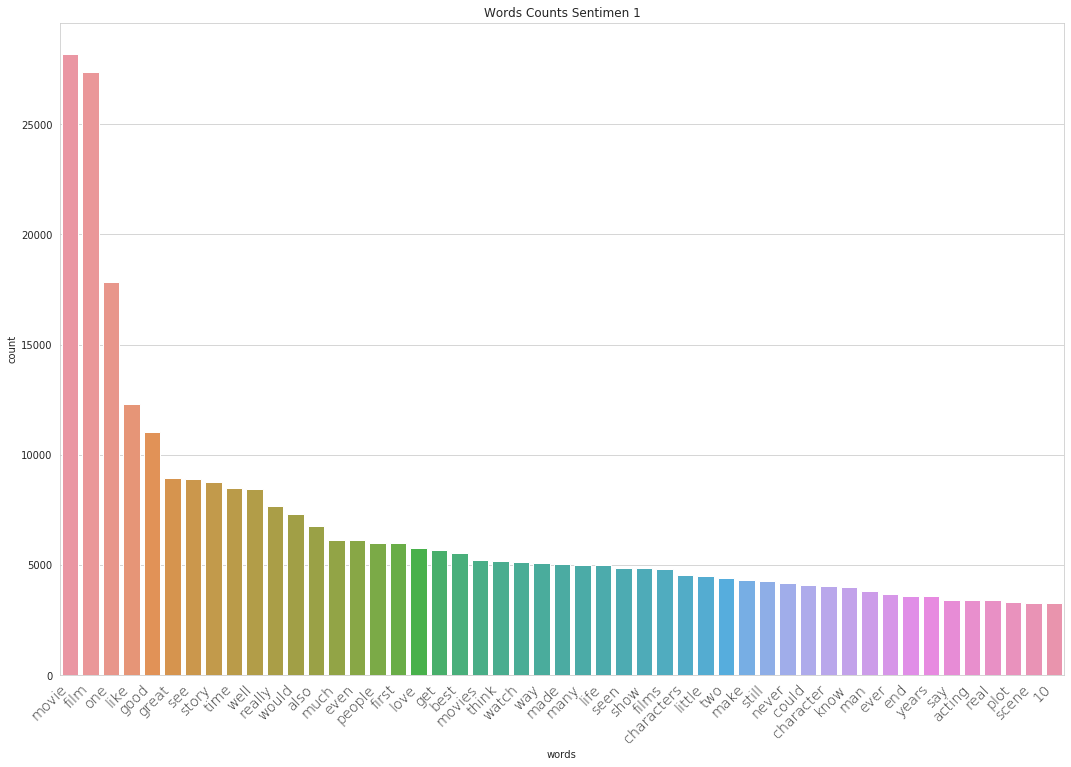

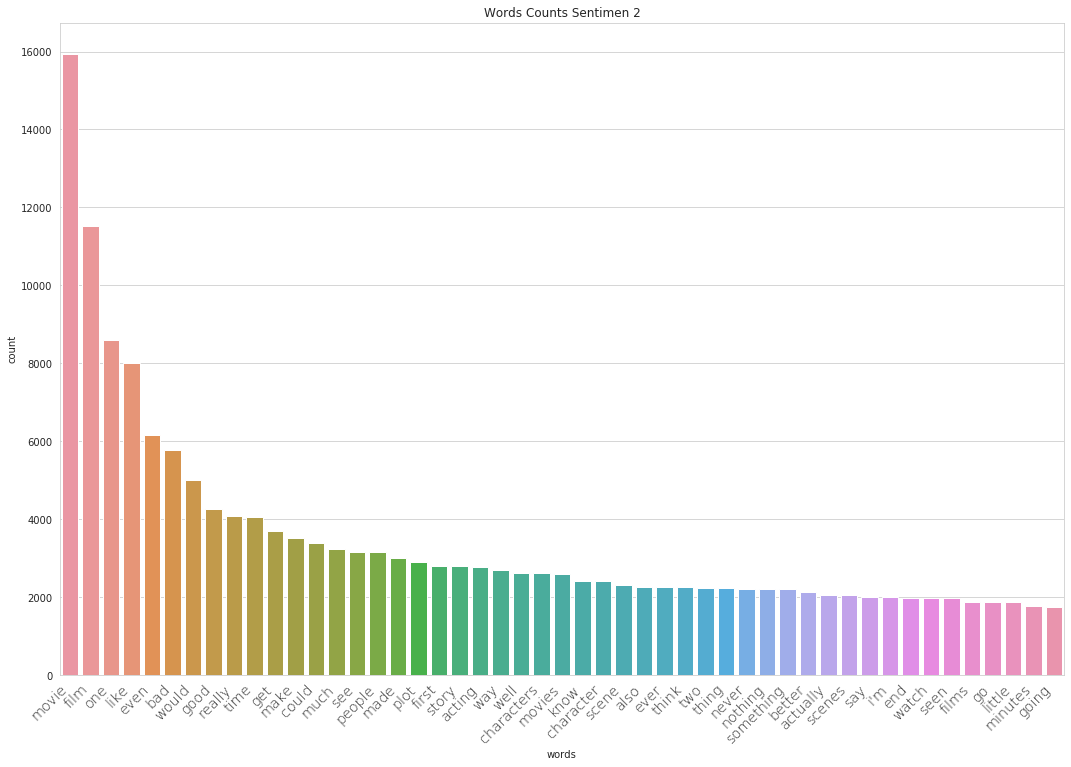

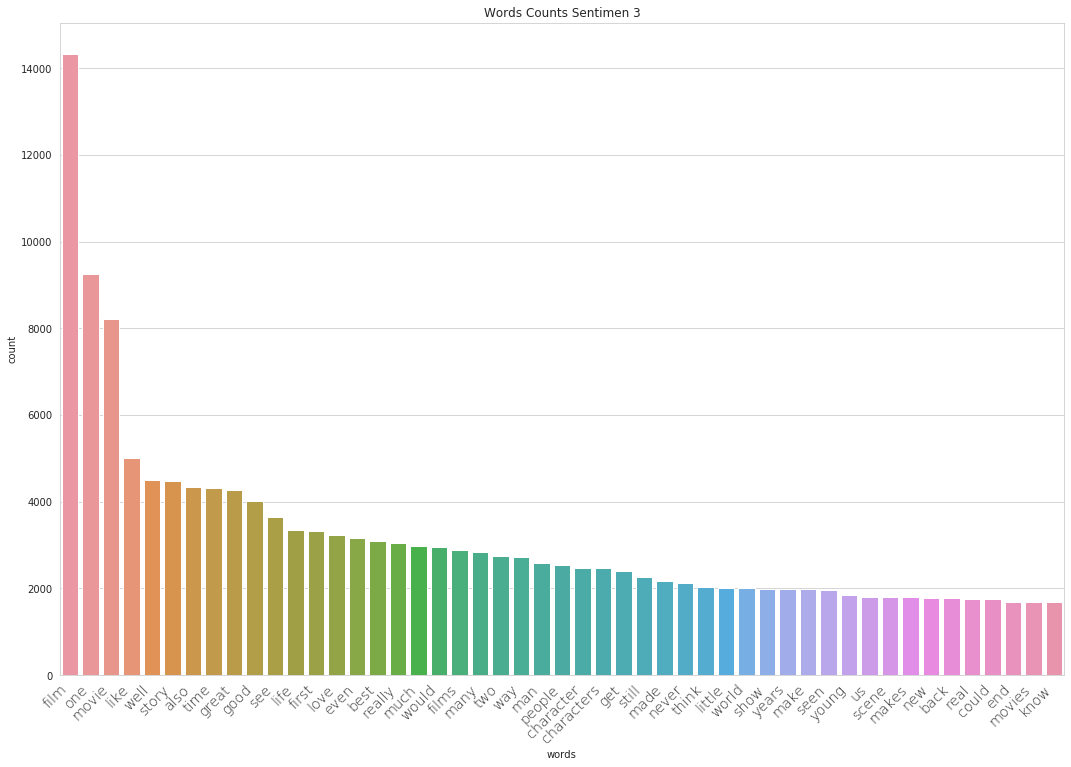

In [27]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), #None, #stopwords.words('english'), 
                    magnify=3)

### Visualize

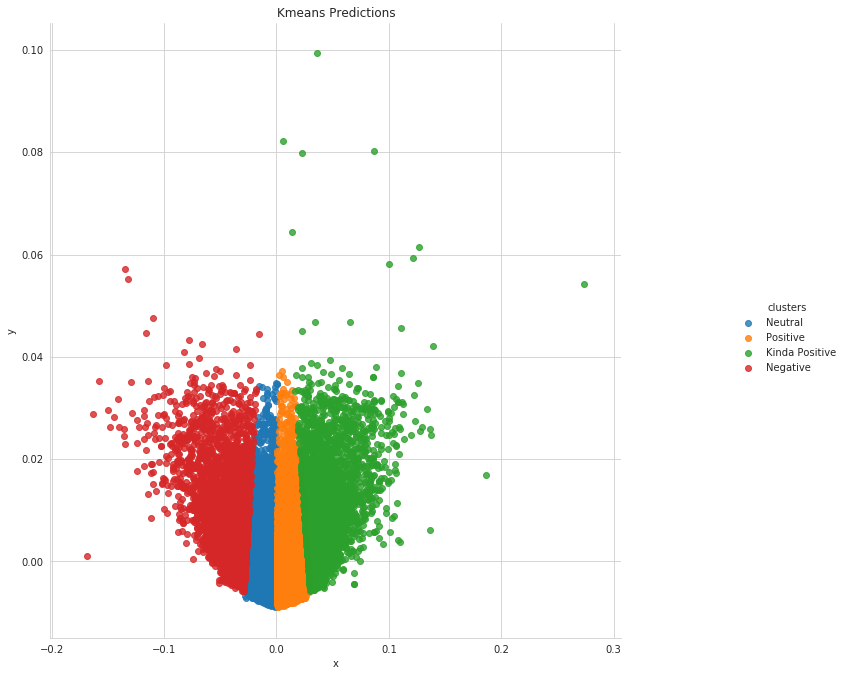

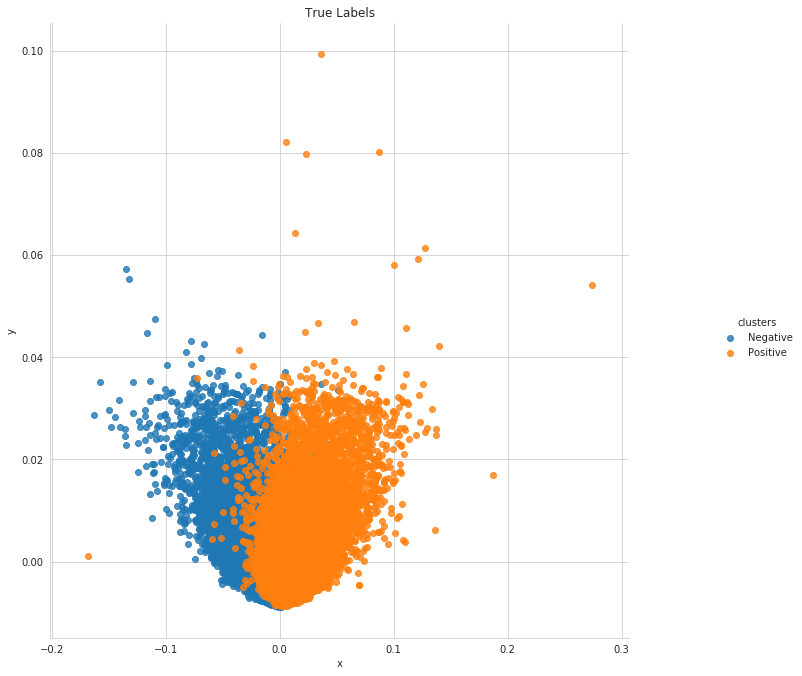

In [28]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative',
                       3:'Kinda Positive'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [29]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                        trues=reviews_sentiments, 
                        trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                        predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  \
0  I watched this movie alongwith my complete family of Nine. Since my younger brother has recently got married, we could connect with the goings-on. The movie stands out for the classical touch given to the romance of the engaged couple. Thankfully this time all Indian locales like Ranikhet Almora etc have been used, which have been already visited by most of the urbanites, hence adding to the connection with movie. The dialogues are much better than those in the "Umrao Jaan Ada" - a supposedly dialogue based movie. The background music is augmenting the "soft focus" of the movie. It somehow remind me of VV Chopra's "Kareeb", in which neha and to some extent Bobby did full justice to the character. Same here, in that the lead pair does not disappoint in any department-looks or acting. The Supporting cast are too good. I rate the actress playing the role of Bhabhi in the front league. The situations of family interactions portrayed are real and you smile when you find yourself in place of one of the characters. Songs were too suiting the scenes and going along well with the movie. However, though I respect Ravindra Jain for his body of work from movies to Ramayana, I missed Ram Laxman badly.<br /><br />It had no double entendres(Sivan category), no bikinis, no intrigue, and no nonsense. You would comfortably watch the movie with your parents except if you're already or going to be soon engaged. I want to express on candid thing here that though Suraj proposes that the marriages is between families and not only individuals, his approach is totally individualistic. The movie is only about Prem & Poonam, rest of the characters are incidental. Art immitating life? The "peripheral characters" are consigned to the background and the only protagonists are the lead pair. <br /><br />Coming back, Everything was almost great. Except, for the drama part. The situation of tragedy was artificially created. The outcome, the sacrifice and the ensuing heart change are not compelling at all. That is why it lacks the emotional punch-the very purpose of this turn of events. But, a twist in the tale was necessary to transcend the movie from a beautiful pre-marital video to a 'feature film'. But I kept waiting for the punch and it never came. The preaching by Mohnish Bahal and later by Alok Nath on dowry was out of place and it made things too overboard. May be this will help the movie a tax-free status. But the plot could have been made more interesting and non-linear than what it was.<br /><br />There were too question in my mind when the movie ended: 1 Has the movie really ended? 2 Has the movie ended?   
1  ATTENTION, SPOILER!<br /><br />Many people told me that «Planet of the Apes» was Tim Burton's worst movie and apart from that much weaker than the original film. So I decided not to see it. Another friend of mine who hadn't seen the movie yet, advised me to watch it in spite of this because `a Tim-Burton-movie is still a Tim-Burton-movie'. I decided to do it, and I found that he was right.<br /><br />It's clear that a remake of such a famous film as `Planet of the Apes' is automatically influenced by commercial thinking. Still, Tim Burton managed his film to represent his weird playfulness just as well as `Beetlejuice' or `Batman'. If you are already fond of Burton-movies, it's hard not to like one of his films, even if it has some flaws: nerve-racking monkey squeals, over-dressed apes and a leading actor who could have been, without difficulties, replaced by anbody else.<br /><br />What the film gives us in the first place, is an answer to the question: What's the result when Tim Burton is instructed to create a remake? First of all, Burton wouldn't be Burton, if he wouldn't refuse to call it a remake from the start; it's a `re-imagining'. On the other hand, Burton knows that almost every viewer of his movie has seen the very first film version starring Charlton Heston (as human), and he knows that a remake doesn't exist without it

# Custom Samples

In [30]:
custom_text = "This workshop roks!!"

encoding = text_features.encode(custom_text)
encoding = tf.keras.preprocessing.sequence.pad_sequences(sequences=[encoding], 
                                                       maxlen=MAX_LEN, 
                                                       dtype='int64', 
                                                       padding='post', 
                                                       truncating='post', 
                                                       value=0)
embedding = embedding_model(encoding)
kmean_label = kmean_model.predict(tf.get_static_value(embedding))[0]

print('Text: ',custom_text)
print('Sentiment: ', kmeans_id_sentiment[kmean_label])

Text:  This workshop roks!!
Sentiment:  Positive
